In [5]:
import os
import numpy as np
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV


# PREDICCIONES DE LOS MEJORES MODELOS EN EL CONJUNTO DE PRUEBA

## Stacking

In [12]:
train = pd.read_csv("Data/train_2.csv")
test= pd.read_csv("Data/test_2.csv")


In [13]:
# Verificar columnas con NaN en el conjunto de test
nan_columns_test = test.columns[test.isna().any()].tolist()
nan_counts = test[nan_columns_test].isna().sum()

# Mostrar las columnas con NaN y su conteo
nan_info = pd.DataFrame({'Column': nan_columns_test, 'NaN Count': nan_counts})
print(nan_info)

Empty DataFrame
Columns: [Column, NaN Count]
Index: []


In [15]:
# Cargar el scaler
scaler = joblib.load('Data/minmax_scaler.pkl')

# Separar características y variable objetivo
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

# Normalización de los datos usando MinMaxScaler
X_scaled = scaler.fit_transform(X)  # Ajustar y transformar el conjunto completo de entrenamiento
X_test = test.drop(columns=['Id'])  # Eliminar la columna 'Id' del conjunto de test
X_test_scaled = scaler.transform(X_test)  # Solo transformar el conjunto de prueba

# Definir combinaciones de modelos base
base_models_1 = [
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgboost', XGBRegressor(n_estimators=100, random_state=42))
]
# Definir el metamodelo (meta_model_current) con los hiperparámetros optimizados
meta_model_current = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.8,
    lambda_=0,
    gamma=1,
    random_state=42
)

# Definir el modelo de stacking
stacking_model = StackingRegressor(estimators=base_models_1, final_estimator=meta_model_current)

# Ajustar el modelo de stacking en el conjunto de entrenamiento completo
stacking_model.fit(X_scaled, y)

# Realizar predicciones en el conjunto de test
test_predictions = stacking_model.predict(X_test_scaled)

# Crear un DataFrame para las predicciones
submission = pd.DataFrame({
    'Id': test['Id'],  # Usar la columna 'Id' del conjunto de test
    'SalePrice': test_predictions
})

# Guardar las predicciones en un archivo CSV
submission.to_csv('Data/submission_stacking.csv', index=False)

print("Predicciones guardadas en 'Data/submission_stacking.csv'")


Predicciones guardadas en 'Data/submission_stacking.csv'


C:\Users\oscar\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


![Resultados para el stacking](Images/stacking.png)


## Gradient Boost

In [19]:
# Cargar los datos
train = pd.read_csv("Data/train_2.csv")
test = pd.read_csv("Data/test_2.csv")

# Separar características y variable objetivo
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

# Eliminar la columna 'Id' antes de pasar al modelo
X_test = test.drop(columns=['Id'])

# Definir el modelo con los mejores hiperparámetros encontrados
gb_model = GradientBoostingRegressor(
    n_estimators=2500,
    learning_rate=0.01,
    max_depth=4,
    subsample=1.0,
    max_features='sqrt',
    random_state=42
)

# Ajustar el modelo en el conjunto de entrenamiento completo
gb_model.fit(X, y)

# Realizar predicciones en el conjunto de test sin escalar
test_predictions = gb_model.predict(X_test)

# Crear un DataFrame para las predicciones
submission = pd.DataFrame({
    'Id': test['Id'],  # Asegúrate de que la columna 'Id' esté presente en el conjunto de test
    'SalePrice': test_predictions
})

# Guardar las predicciones en un archivo CSV
submission.to_csv('Data/submission_gb.csv', index=False)

print("Predicciones guardadas en 'Data/submission_gb.csv'")


Predicciones guardadas en 'Data/submission_gb.csv'


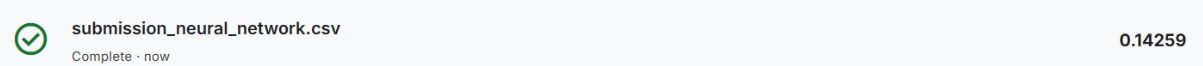![Resultados para gradient](Images/gradient.png)


## XGBoost

In [16]:
# Cargar los datos
train = pd.read_csv("Data/train_2.csv")
test = pd.read_csv("Data/test_2.csv")

# Separar características y variable objetivo
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

# Eliminar la columna 'Id' antes de pasar al modelo
X_test = test.drop(columns=['Id'])

# Definir el modelo con los mejores hiperparámetros encontrados
xgb_model = XGBRegressor(
    n_estimators=2500,
    learning_rate=0.015,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=0.3,
    random_state=42
)

# Ajustar el modelo en el conjunto de entrenamiento completo
xgb_model.fit(X, y)

# Realizar predicciones en el conjunto de test sin escalar
test_predictions = xgb_model.predict(X_test)

# Crear un DataFrame para las predicciones
submission = pd.DataFrame({
    'Id': test['Id'],  # Asegúrate de que la columna 'Id' esté presente en el conjunto de test
    'SalePrice': test_predictions
})

# Guardar las predicciones en un archivo CSV
submission.to_csv('Data/submission_xgb.csv', index=False)

print("Predicciones guardadas en 'Data/submission_xgb.csv'")

Predicciones guardadas en 'Data/submission_xgb.csv'


![Resultados para xgb](Images/xgb.png)


## Red Neuronal

In [4]:
# Cargar los datos
cleaned_data = pd.read_csv("Data/train_2.csv")
test_data = pd.read_csv("Data/test_2.csv")

# Separar las características y la variable objetivo
X = cleaned_data.drop(columns=['SalePrice'])
y = cleaned_data['SalePrice']

# Normalización de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Ajustar y transformar el conjunto completo de entrenamiento
X_test_scaled = scaler.transform(test_data.drop(columns=['Id']))  # Solo transformar el conjunto de prueba sin 'Id'

mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42
)

# Entrenar el modelo con el 100% de los datos de entrenamiento
mlp_model.fit(X_scaled, y)

# Hacer predicciones en el conjunto de test
test_predictions = mlp_model.predict(X_test_scaled)

# Crear un DataFrame para las predicciones
submission = pd.DataFrame({
    'Id': test_data['Id'],  # Asegúrate de que la columna 'Id' esté presente en el conjunto de test
    'SalePrice': test_predictions
})

# Guardar las predicciones en un archivo CSV
submission.to_csv('Data/submission_neural_network.csv', index=False)

print("Predicciones guardadas en 'Data/submission_neural_network.csv'")

Predicciones guardadas en 'Data/submission_neural_network.csv'


![Resultados para xgb](Images/rede.png)


Los resultados son en general razonables, parece que los dos modelos que sobreajustaban en exceso (**GBT** y **XGB**) tienen un rendimiento algo superior a los que generalizaban mejor (**stacking** y **red**). De esto se puede concluir que los datos del conjunto de prueba son muy similares a los del de entrenamiento. Seguramente la **red neuronal** funcionaría mejor con datos menos homogéneos.
